In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import copy
import pickle
from torchvision import transforms

from get3d_utils import constructGenerator, eval_get3d_angles, generate_rotate_camera_list, save_textured_mesh

In [4]:
def preprocess_rgb(array):
    img = array
    img = transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])(img)
    img = img.transpose(1, 3)
    img = img.transpose(1, 2)
    img = img.clip(0., 1.)
    return img.cpu().numpy()

In [5]:
with open('test.pickle', 'rb') as f:
        generator_args = pickle.load(f)

G_ema = constructGenerator(**generator_args)

constructing
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
==> resume from pretrained path pretrained_model/shapenet_car.pt


In [6]:
torch.manual_seed(0)

In [7]:

#loss_types = ['pae']

edited_state = torch.load(f'generators_saved/8_batch_240_samples_Sports Car_pae_generator.pt')

In [8]:
import copy

original_state_dict = copy.deepcopy(G_ema.state_dict())

In [9]:
n_samples = 10

z_geo = torch.randn(n_samples, 512).to('cuda')
z_tex = torch.randn(n_samples, 512).to('cuda')

with torch.no_grad():
    ws_geo = G_ema.mapping_geo(z_geo, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False)
    ws_tex = G_ema.mapping(z_tex, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False)

In [10]:
# Rendering Images

with torch.no_grad():
    camera_idxs = [0, 4, 8, 12, 16]
    cameras = generate_rotate_camera_list()
    cameras = [camera for i, camera in enumerate(cameras) if i in camera_idxs]
    imgs = []
    G_ema.load_state_dict(original_state_dict)
    for i, _ in enumerate(ws_geo):
        img_original = eval_get3d_angles(G_ema, ws_geo[i].unsqueeze(0).clone(), ws_tex[i].unsqueeze(0).clone(), cameras=cameras, intermediate_space=True).cpu()
        imgs.append(img_original)
    G_ema.load_state_dict(edited_state)
    for i, _ in enumerate(ws_geo):
        if i == 0:
             save_textured_mesh(G_ema, ws_geo[i].unsqueeze(0).clone(), ws_tex[i].unsqueeze(0).clone(), f'out_of_domain_examples/ferrari.obj')
        img_edited = eval_get3d_angles(G_ema, ws_geo[i].unsqueeze(0).clone(), ws_tex[i].unsqueeze(0).clone(), cameras=cameras, intermediate_space=True).cpu()
        imgs.append(img_edited)
    torch.cuda.empty_cache()

/home/windows-ssh/git/GET3D/get3d_utils.py:351: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device='cuda').unsqueeze(dim=-1) / n_camera * math.pi * 2.0


In [11]:
imgs = torch.cat(imgs)

In [12]:
with torch.no_grad():
    preprocessed_imgs = preprocess_rgb(imgs)

In [13]:
preprocessed_imgs = preprocessed_imgs.reshape(-1, n_samples, len(cameras), 1024, 1024, 3).swapaxes(0, 1).reshape(-1, 1024, 1024, 3)

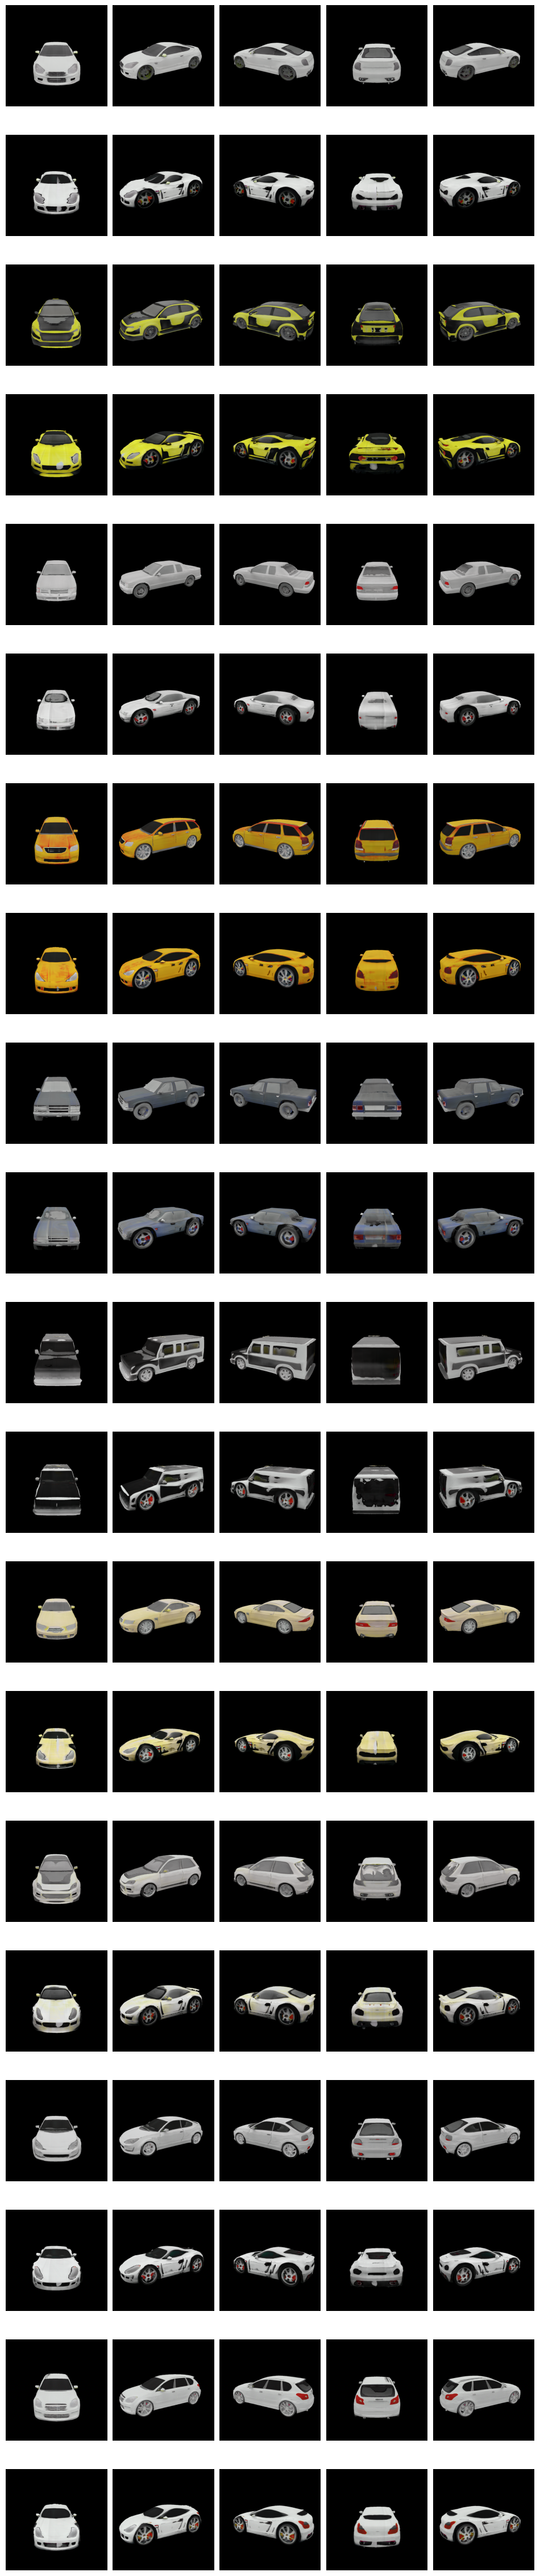

In [14]:
from mpl_toolkits.axes_grid1 import ImageGrid

n_show = 10

fig = plt.figure(figsize=(12., 200.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n_show * 2, len(cameras)),
                 axes_pad=(0.1, 0.5),
                 )

for i, (ax, im) in enumerate(zip(grid, preprocessed_imgs[:n_show * 2 * len(cameras)])):
    ax.axis('off')
    #ax.set_title(f'{i}')
    ax.imshow(im)

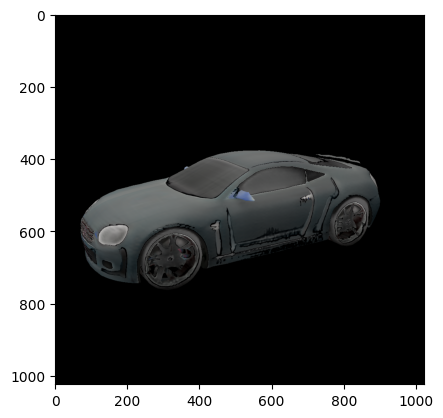

In [15]:
plt.imshow(preprocessed_imgs[6])

In [17]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
n_cameras = 3
with open(f'weight_transform_90_samples_Sports Car_directional_train_val_loss.pickle', 'rb') as f:
    loss_dict_directional = pickle.load(f)
with open(f'weight_transform_90_samples_Sports Car_pae_train_val_loss.pickle', 'rb') as f:
    loss_dict_pae = pickle.load(f)

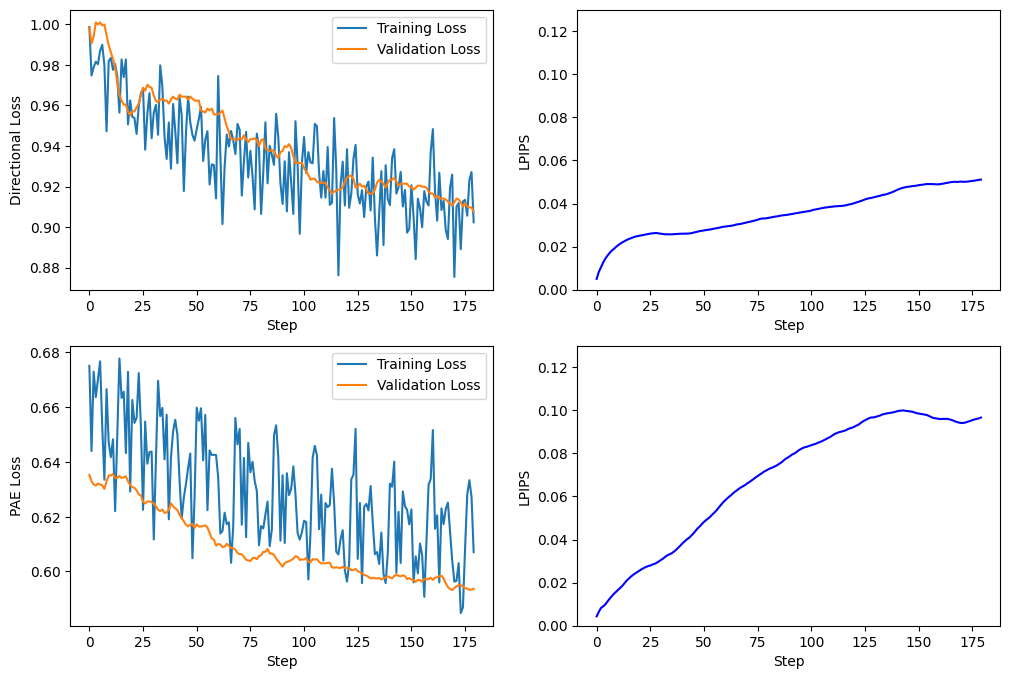

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0][0].plot(np.array(loss_dict_directional['train_loss']) / 7, label='Training Loss')
ax[0][0].plot(loss_dict_directional['val_loss'], label='Validation Loss')
ax[0][0].legend()
ax[0][1].plot(loss_dict_directional['lpips'], label='LPIPS', c='b')
ax[0][1].set_ylim(0, 0.13)
ax[0][0].set_xlabel('Step')
ax[0][0].set_ylabel('Directional Loss')
ax[0][1].set_xlabel('Step')
ax[0][1].set_ylabel('LPIPS')
ax[1][0].plot(np.array(loss_dict_pae['train_loss']), label='Training Loss')
ax[1][0].plot(loss_dict_pae['val_loss'], label='Validation Loss')
ax[1][0].legend()
ax[1][1].plot(loss_dict_pae['lpips'], label='LPIPS', c='b')
ax[1][1].set_ylim(0, 0.13)
ax[1][0].set_xlabel('Step')
ax[1][0].set_ylabel('PAE Loss')
ax[1][1].set_xlabel('Step')
ax[1][1].set_ylabel('LPIPS')



plt.show()
fig.savefig('LPIPS pae vs directional.png')
# ax.plot(np.array(loss_dict['train']), label='Training Loss')
# ax.plot(np.array(loss_dict['val']), label='Validation Loss')

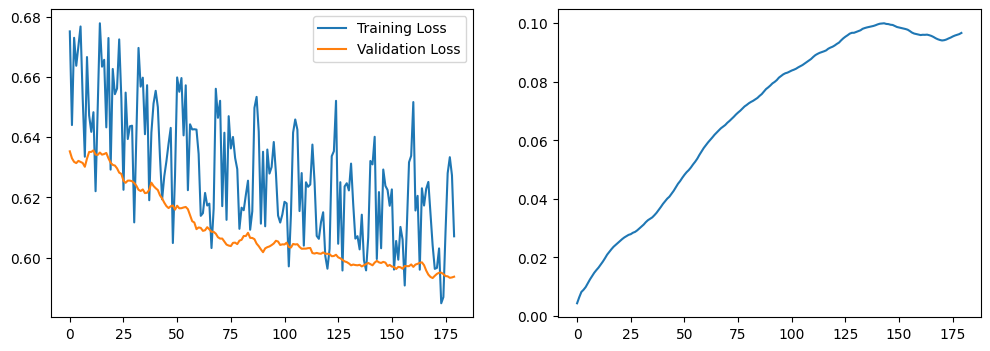

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(loss_dict['train_loss'], label='Training Loss')
ax[0].plot(loss_dict['val_loss'], label='Validation Loss')
ax[1].plot(loss_dict['lpips'], label='LPIPS')
ax[0].legend()
# ax.plot(np.array(loss_dict['train']), label='Training Loss')
# ax.plot(np.array(loss_dict['val']), label='Validation Loss')

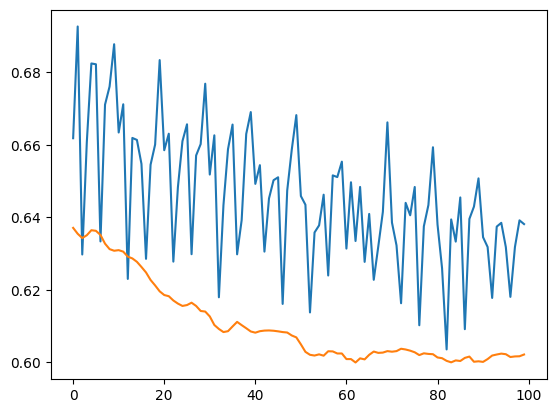

In [4]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')

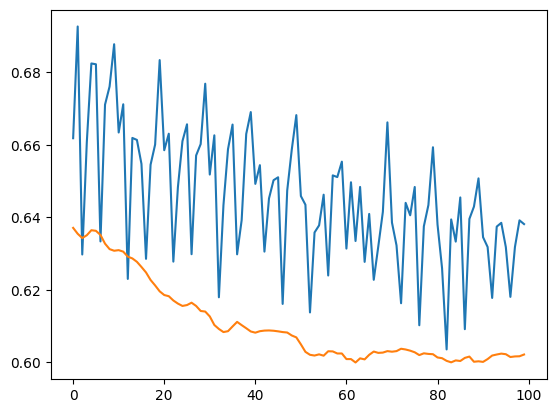

In [4]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')

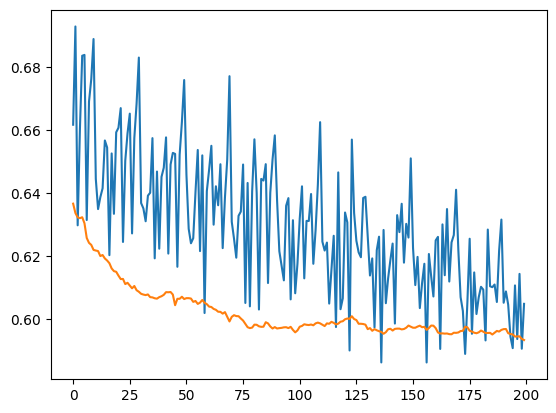

In [2]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')

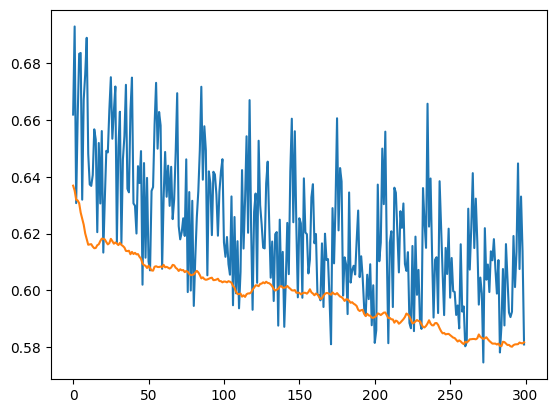

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')

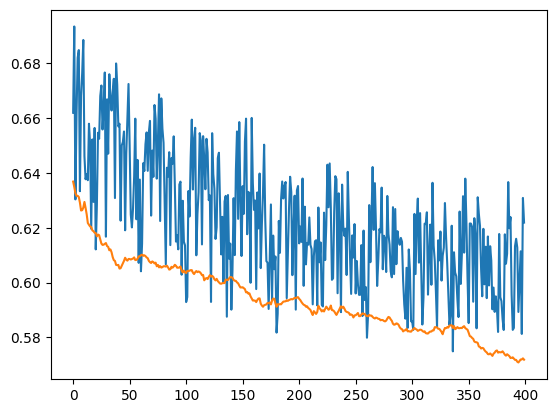

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')